In [ ]:
!wget --quiet -P /tmp https://i.ytimage.com/vi/YCaGYUIfdy4/maxresdefault.jpg
!wget --quiet -P /tmp https://upload.wikimedia.org/wikipedia/commons/b/b4/Vincent_Willem_van_Gogh_128.jpg

Eager execution: True


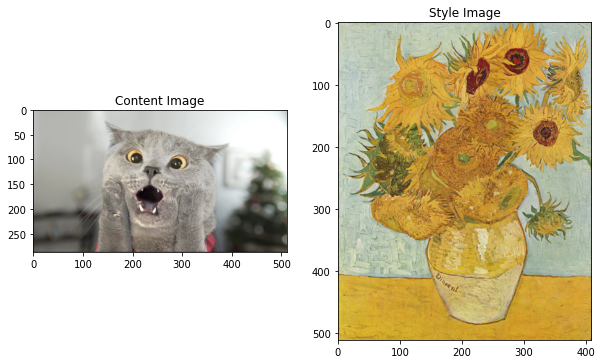

In [ ]:
Content_Path = '/tmp/maxresdefault.jpg'
Style_Path = '/tmp/Vincent_Willem_van_Gogh_128.jpg'

import os
import time
import functools
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

def load_image(Path_to_image):
  max_dim = 512
  image = Image.open(Path_to_image)
  long = max(image.size)
  scale = max_dim/long

  image = image.resize((round(image.size[0]*scale), round(image.size[1]*scale)), Image.ANTIALIAS)
  image = kp_image.image_to_array(image)
  image = np.expand_dims(image, axis=0)
  return image

def imshow(image, title=None):
  Output = np.squeeze(image, axis=0)
  Output = Output.astype('uint8')
  plt.imshow(Output)

  if title is not None:
    plt.title(title)
  plt.imshow(Output)

plt.figure(figsize=(10,10))
Content = load_image(Content_Path).astype('uint8')
Style = load_image(Style_Path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(Content, 'Content Image')
plt.subplot(1, 2, 2)
imshow(Style, 'Style Image')
plt.show()

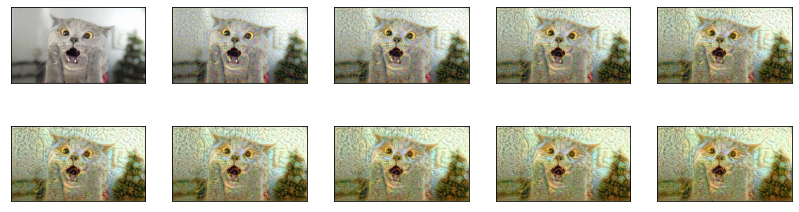

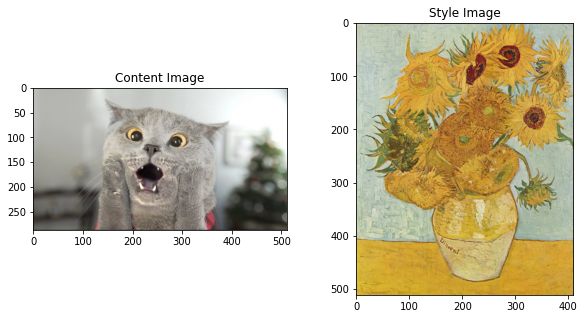

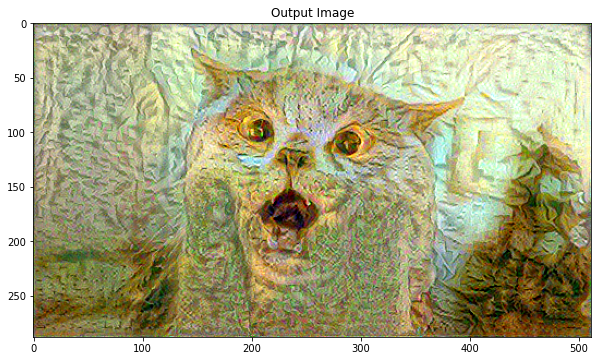

In [ ]:
def load_and_process_image(Path_to_image):
  image = load_image(Path_to_image)
  image = tf.keras.applications.vgg19.preprocess_input(image)
  return image

def deprocess_image(processed_image):
  x = processed_image.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

Content_layers = ['block5_conv2'] 
Style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_Content_layers = len(Content_layers)
num_Style_layers = len(Style_layers)

def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  Style_Outputs = [vgg.get_layer(name).output for name in Style_layers]
  Content_Outputs = [vgg.get_layer(name).output for name in Content_layers]
  model_Outputs = Style_Outputs + Content_Outputs
  return models.Model(vgg.input, model_Outputs)

def get_Content_loss(base_Content, target):
  return tf.reduce_mean(tf.square(base_Content - target))

def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_Style_loss(base_Style, gram_target):
  height, width, channels = base_Style.get_shape().as_list()
  gram_Style = gram_matrix(base_Style)
  
  return tf.reduce_mean(tf.square(gram_Style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

def get_feature_representations(model, Content_Path, Style_Path):
  Content_image = load_and_process_image(Content_Path)
  Style_image = load_and_process_image(Style_Path)
  
  # batch compute Content and Style features
  Style_Outputs = model(Style_image)
  Content_Outputs = model(Content_image)
  
  
  # Get the Style and Content feature representations from our model  
  Style_features = [Style_layer[0] for Style_layer in Style_Outputs[:num_Style_layers]]
  Content_features = [Content_layer[0] for Content_layer in Content_Outputs[num_Style_layers:]]
  return Style_features, Content_features

def compute_loss(model, loss_weights, init_image, gram_Style_features, Content_features):
  Style_weight, Content_weight = loss_weights
  model_Outputs = model(init_image)
  
  Style_output_features = model_Outputs[:num_Style_layers]
  Content_output_features = model_Outputs[num_Style_layers:]
  
  Style_score = 0
  Content_score = 0

  weight_per_Style_layer = 1.0 / float(num_Style_layers)
  for target_Style, comb_Style in zip(gram_Style_features, Style_output_features):
    Style_score += weight_per_Style_layer * get_Style_loss(comb_Style[0], target_Style)
    
  weight_per_Content_layer = 1.0 / float(num_Content_layers)
  for target_Content, comb_Content in zip(Content_features, Content_output_features):
    Content_score += weight_per_Content_layer* get_Content_loss(comb_Content[0], target_Content)
  
  Style_score *= Style_weight
  Content_score *= Content_weight

  loss = Style_score + Content_score 
  return loss, Style_score, Content_score

def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

import IPython.display

def run_Style_transfer(Content_Path, 
                       Style_Path,
                       num_iterations=1000,
                       Content_weight=1e3, 
                       Style_weight=1e-2): 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  Style_features, Content_features = get_feature_representations(model, Content_Path, Style_Path)
  gram_Style_features = [gram_matrix(Style_feature) for Style_feature in Style_features]
  
  init_image = load_and_process_image(Content_Path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  iter_count = 1
  best_loss, best_image = float('inf'), None
  
  loss_weights = (Style_weight, Content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_Style_features': gram_Style_features,
      'Content_features': Content_features }
    
  Rows = 2
  Cols = 5
  display_interval = num_iterations/(Rows*Cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  images = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, Style_score, Content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      best_loss = loss
      best_image = deprocess_image(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      plot_image = init_image.numpy()
      plot_image = deprocess_image(plot_image)
      images.append(plot_image)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_image))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'Style loss: {:.4e}, '
            'Content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, Style_score, Content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,image in enumerate(images):
      plt.subplot(Rows,Cols,i+1)
      plt.imshow(image)
      plt.xticks([])
      plt.yticks([])
      
  return best_image, best_loss 

best, best_loss = run_Style_transfer(Content_Path, 
                                     Style_Path, num_iterations=100)

Image.fromarray(best)

def show_results(best_image, Content_Path, Style_Path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  Content = load_image(Content_Path) 
  Style = load_image(Style_Path)

  plt.subplot(1, 2, 1)
  imshow(Content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(Style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_image)
    plt.title('Output Image')
    plt.show()

show_results(best, Content_Path, Style_Path)